In [1]:
import math

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
# Method to calculate the haversine distance between two coordinates
def haversine_distance(source, destination):
    source_lat, source_lon = source
    dest_lat, dest_lon = destination
    
    # Radius of the Earth in kilometers
    earth_radius = 6371

    dlat = math.radians(dest_lat - source_lat)
    dlon = math.radians(dest_lon - source_lon)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(source_lat)) * math.cos(
        math.radians(dest_lat)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance

In [3]:
# Landmark Distances
jfk_coordinates = (40.6413, -73.7781)
lga_coordinates = (40.7769, -73.8740)
times_sq_coordinates = (40.7580, -73.9855)
empire_state_coordinates = (40.7484, -73.9857)
central_park_coordinates = (40.7829, -73.9654)

In [4]:
# Rush hours
rush_hours = [7, 8, 9, 16, 17, 18]

In [5]:
def add_features(df):
    # Haversine distance feature
    df['haversine_distance'] = df.apply(
        lambda row: haversine_distance(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        ),
        axis=1
    )

    # Temporal features
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['weekday'] = df['pickup_datetime'].dt.weekday
    df['hour'] = df['pickup_datetime'].dt.hour

    # Delta diff features
    df['diff_lat'] = df['pickup_latitude'] - df['dropoff_latitude']
    df['diff_lon'] = df['pickup_longitude'] - df['dropoff_longitude']

    # Landmark distance features
    df['pickup_from_jfk'] = df.apply(
        lambda row: haversine_distance((row['pickup_latitude'], row['pickup_longitude']), jfk_coordinates),
        axis=1
    )
    df['pickup_from_lga'] = df.apply(
        lambda row: haversine_distance((row['pickup_latitude'], row['pickup_longitude']), lga_coordinates),
        axis=1
    )
    df['pickup_from_times_sq'] = df.apply(
        lambda row: haversine_distance((row['pickup_latitude'], row['pickup_longitude']), times_sq_coordinates),
        axis=1
    )
    df['pickup_from_empire_state'] = df.apply(
        lambda row: haversine_distance((row['pickup_latitude'], row['pickup_longitude']), empire_state_coordinates),
        axis=1
    )
    df['pickup_from_central_park'] = df.apply(
        lambda row: haversine_distance((row['pickup_latitude'], row['pickup_longitude']), central_park_coordinates),
        axis=1
    )

    # Passenger count (assume one passenger if not provided)
    if 'passenger_count' not in df.columns:
        df['passenger_count'] = 1
    
    # If in rush hour (7-9 AM, 4-6 PM)
    df['is_rush_hour'] = df['hour'].isin(rush_hours).astype(int)

    return df

In [6]:
def transform_train_data(df):
    df = add_features(df)

    # Drop unnecessary columns to avoid noise in the model
    df = df.drop([
        'key',
        'pickup_datetime',
        'pickup_latitude',
        'pickup_longitude',
        'dropoff_latitude',
        'dropoff_longitude'
    ], axis=1, errors='ignore')

    # Drop outliers for training (99.9 percentile cap for fare amount)
    fare_cap = df['fare_amount'].quantile(0.999)
    df = df[df['fare_amount'] < fare_cap]

    return df

In [7]:
# Load the data and transform it
original_train_data = pd.read_csv(
    '../dataset/train_small.csv', # Change to large training set (train.csv) for full training
    parse_dates=['pickup_datetime']
)
df_train = transform_train_data(original_train_data)

# Define target and features
Y = df_train['fare_amount']
X = df_train.drop(['fare_amount'], axis=1, errors='ignore')

# Split the data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
# Evaluate features with K-fold cross validation
K = 10
model = XGBRegressor(objective ='reg:squarederror')
scores = cross_val_score(model, X_train, Y_train, cv=K, scoring='neg_mean_squared_error', verbose=False)
avg_rmse = math.sqrt(abs(np.mean(scores)))

print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))

Average RMSE with 10-fold Cross Validation: 3.764


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

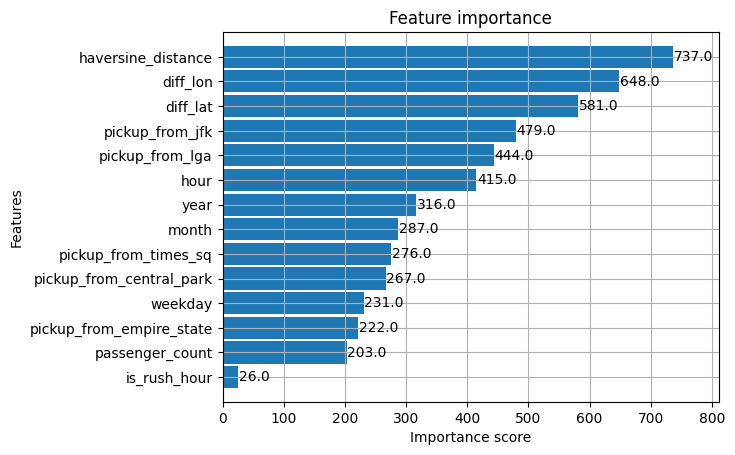

In [9]:
# Train the model
model = XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, Y_train)
xgb.plot_importance(model, height=0.9)

In [10]:
# Predict on the test set
Y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")

Root Mean Squared Error (RMSE): 3.929
R2 Score: 0.819
